In [1]:
import sys,os
import numpy as np
import pylab as py
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import quad,dblquad,fixed_quad
import fDSS
%matplotlib inline  
%config InlineBackend.figure_format = 'retina' 
from  matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)

In [2]:
class FDSS(object):
  
  def __init__(self,order=None,hadron=None,charge=None):
    if order=='LO':  self.io=0
    if order=='NLO': self.io=1
    if   hadron=='pion'    : self.ih=1
    elif hadron=='kaon'    : self.ih=2
    elif hadron=='proton'  : self.ih=3
    elif hadron=='chadrons': self.ih=4
    self.ic=charge
      
  def get_FF(self,flav,x,Q2):
    u,ub,d,db,s,sb,c,b,g = fDSS.fdss(self.ih,self.ic,self.io,x,Q2)
    if   flav=='u' : return u/x
    elif flav=='ub': return ub/x
    elif flav=='d' : return d/x
    elif flav=='db': return db/x
    elif flav=='s' : return s/x
    elif flav=='sb': return sb/x
    elif flav=='c' : return s/x
    elif flav=='b' : return b/x
    elif flav=='g' : return g/x

In [15]:
class FragFuncs(object):

  def __init__(self,fname):

    self.D={}
    self.load_table(fname)

  def load_table(self,fname):

    # read file
    F=open(fname,'r')
    L=F.readlines()
    F.close()

    # convert loaded file to floats
    L=[l.strip() for l in L]
    L=[[float(x) for x in l.split()] for l in L]

    # extract parts
    Q2=np.copy(L[0])
    X=np.copy(L[1])
    L=np.array(L[2:])

    # get number of partons in table
    npartons=len(L[0])

    # empy array for FF values
    FF=np.zeros((npartons,Q2.size,X.size))

    # fill array
    cnt=0
    for iX in range(X.size-1):
      for iQ2 in range(Q2.size):
        for iparton in range(npartons):
          if any([iparton==k for k in [0,1,2,6,7,8]]) : 
            factor=(1-X[iX])**4 * X[iX]**0.5
          elif any([iparton==k for k in [3,4]]) : 
            factor=(1-X[iX])**7 * X[iX]**0.3
          elif iparton==5: 
            factor=(1-X[iX])**4 * X[iX]**0.3
          FF[iparton,iQ2,iX]=L[cnt,iparton]#/factor
        cnt+=1

    LX=np.log(X)
    LQ2=np.log(Q2)

    kx,ky=3,3
    D = self.D
    D['UTOT']=RectBivariateSpline(LQ2,LX,FF[0],kx=kx,ky=ky)
    D['DTOT']=RectBivariateSpline(LQ2,LX,FF[1],kx=kx,ky=ky)
    D['STOT']=RectBivariateSpline(LQ2,LX,FF[2],kx=kx,ky=ky)
    D['CTOT']=RectBivariateSpline(LQ2,LX,FF[3],kx=kx,ky=ky)
    D['BTOT']=RectBivariateSpline(LQ2,LX,FF[4],kx=kx,ky=ky)
    D['G']   =RectBivariateSpline(LQ2,LX,FF[5],kx=kx,ky=ky)
    D['UVAL']=RectBivariateSpline(LQ2,LX,FF[6],kx=kx,ky=ky)
    D['DVAL']=RectBivariateSpline(LQ2,LX,FF[7],kx=kx,ky=ky)
    D['SVAL']=RectBivariateSpline(LQ2,LX,FF[8],kx=kx,ky=ky)

    D['Up'] = lambda lQ2,lx: 0.5*(D['UTOT'](lQ2,lx)+D['UVAL'](lQ2,lx))
    D['UBp']= lambda lQ2,lx: 0.5*(D['UTOT'](lQ2,lx)-D['UVAL'](lQ2,lx))
    D['Dp'] = lambda lQ2,lx: 0.5*(D['DTOT'](lQ2,lx)+D['DVAL'](lQ2,lx))
    D['DBp']= lambda lQ2,lx: 0.5*(D['DTOT'](lQ2,lx)-D['DVAL'](lQ2,lx))
    D['Sp'] = lambda lQ2,lx: 0.5*(D['STOT'](lQ2,lx)+D['SVAL'](lQ2,lx))
    D['SBp']= lambda lQ2,lx: 0.5*(D['STOT'](lQ2,lx)-D['SVAL'](lQ2,lx))
    D['Cp'] = lambda lQ2,lx: 0.5*D['CTOT'](lQ2,lx)
    D['Bp'] = lambda lQ2,lx: 0.5*D['BTOT'](lQ2,lx)

  def get_xg(self,x,Q2,charge):
    lx=np.log(x)
    lQ2=np.log(Q2)
    return self.D['G'](lQ2,lx)[0,0]#*(1-x)**4*x**0.3

  def get_xu(self,x,Q2,charge):
    lx=np.log(x)
    lQ2=np.log(Q2)
    return self.D['Up'](lQ2,lx)[0,0]
    D=self.D
    if charge==1:
      return D['Up'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==-1:
      return D['UBp'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==0:
      return 0.5 *(D['Up'](lQ2,lx)[0,0]+D['UBp'](lQ2,lx)[0,0])#*(1-x)**4*x**0.5

  def get_xub(self,x,Q2,charge):
    lx=np.log(x)
    lQ2=np.log(Q2)
    D=self.D
    if charge==1:
      return D['UBp'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==-1:
      return D['Up'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==0:
      return 0.5*(D['Up'](lQ2,lx)[0,0]+D['UBp'](lQ2,lx)[0,0])#*(1-x)**4*x**0.5

  def get_xd(self,x,Q2,charge):
    lx=np.log(x)
    lQ2=np.log(Q2)
    D=self.D
    if charge==1:
      return D['Dp'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==-1:
      return D['DBp'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==0:
      return 0.5*(D['Dp'](lQ2,lx)[0,0]+D['DBp'](lQ2,lx)[0,0])#*(1-x)**4*x**0.5

  def get_xdb(self,x,Q2,charge):
    lx=np.log(x)
    lQ2=np.log(Q2)
    D=self.D
    if charge==1:
      return D['DBp'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==-1:
      return D['Dp'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==0:
      return 0.5*(D['Dp'](lQ2,lx)[0,0]+D['DBp'](lQ2,lx)[0,0])#*(1-x)**4*x**0.5

  def get_xs(self,x,Q2,charge):
    lx=np.log(x)
    lQ2=np.log(Q2)
    D=self.D
    if charge==1:
      return D['Sp'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==-1:
      return D['SBp'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==0:
      return 0.5*(D['Sp'](lQ2,lx)[0,0]+D['SBp'](lQ2,lx)[0,0])#*(1-x)**4*x**0.5

  def get_xsb(self,x,Q2,charge):
    lx=np.log(x)
    lQ2=np.log(Q2)
    D=self.D
    if charge==1:
      return D['SBp'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==-1:
      return D['Sp'](lQ2,lx)[0,0]#*(1-x)**4*x**0.5
    elif charge==0:
      return 0.5*(D['Sp'](lQ2,lx)[0,0]+D['SBp'](lQ2,lx)[0,0])#*(1-x)**4*x**0.5

  def get_xc(self,x,Q2,charge):
    lx=np.log(x)
    lQ2=np.log(Q2)
    D=self.D
    return D['Cp'](lQ2,lx)[0,0]#*(1-x)**7*x**0.3

  def get_xcb(self,x,Q2,charge):
    lx=np.log(x)
    lQ2=np.log(Q2)
    D=self.D
    return D['Cp'](lQ2,lx)[0,0]#*(1-x)**7*x**0.3

  def get_xb(self,x,Q2,charge):
    lx=np.log(x)
    lQ2=np.log(Q2)
    D=self.D
    return D['Bp'](lQ2,lx)[0,0]#*(1-x)**7*x**0.3

  def get_xbb(self,x,Q2,charge):
    lx=np.log(x)
    lQ2=np.log(Q2)
    D=self.D
    return D['Bp'](lQ2,lx)[0,0]#*(1-x)**7*x**0.3

  def get_FF(self,x,Q2,flav,charge):
    if   flav=='g':  return self.get_xg(x,Q2,charge)/x
    elif flav=='u':  return self.get_xu(x,Q2,charge)/x
    elif flav=='ub': return self.get_xub(x,Q2,charge)/x
    elif flav=='d':  return self.get_xd(x,Q2,charge)/x
    elif flav=='db': return self.get_xdb(x,Q2,charge)/x
    elif flav=='s':  return self.get_xs(x,Q2,charge)/x
    elif flav=='sb': return self.get_xsb(x,Q2,charge)/x
    elif flav=='c':  return self.get_xc(x,Q2,charge)/x
    elif flav=='cb': return self.get_xcb(x,Q2,charge)/x
    elif flav=='b':  return self.get_xb(x,Q2,charge)/x
    elif flav=='bb': return self.get_xbb(x,Q2,charge)/x

In [16]:
fdss=FDSS('LO','pion',+1)
FF=FragFuncs('tables/PILO.TAB')
z,Q2=0.8,2.0
print fdss.get_FF('u',z,Q2)
print FF.get_FF(z,Q2,'u',1)
%timeit -n3 -r3 fdss.get_FF('u',z,Q2)
%timeit -n3 -r3 FF.get_FF(z,Q2,'u',1)

0.118824888362
0.118154201086
3 loops, best of 3: 2.7 µs per loop
3 loops, best of 3: 16.7 µs per loop


[]

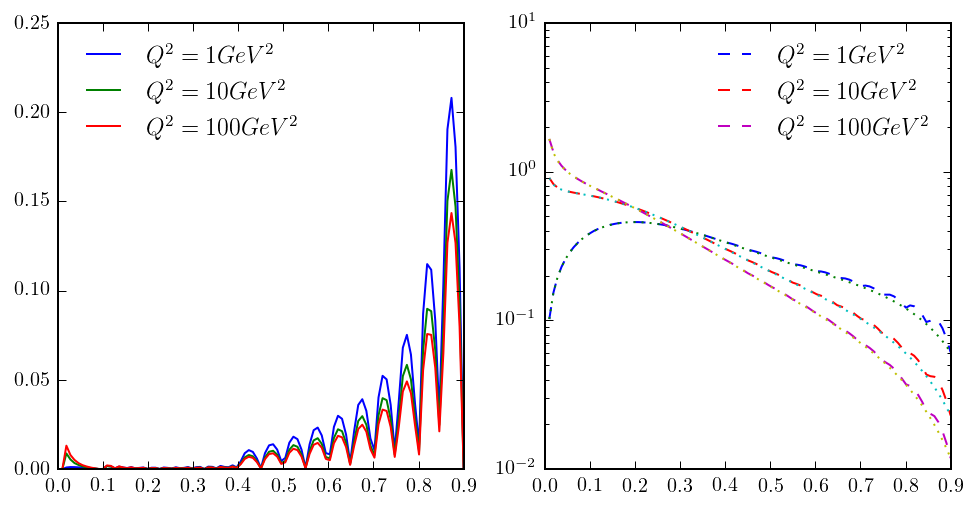

In [19]:
nrows,ncols=1,2
py.figure(figsize=(ncols*4,nrows*4))
ax1=py.subplot(nrows,ncols,1)
ax2=py.subplot(nrows,ncols,2)
flav='u'
Z=np.linspace(1e-2,0.9,100)
for Q2 in [1.0,10.0,100.]:
  FF1=np.array([fdss.get_FF(flav,z,Q2) for z in Z])
  FF2=np.array([FF.get_FF(z,Q2,flav,1) for z in Z])
  ax1.plot(Z,np.abs(FF2-FF1)/FF1,label=r'$Q^2=%0.0fGeV^2$'%Q2)
  ax2.plot(Z,Z*FF1,ls='--',label=r'$Q^2=%0.0fGeV^2$'%Q2)
  ax2.plot(Z,Z*FF2,ls=':')
ax1.legend(frameon=0,loc=2)
ax2.legend(frameon=0,loc=1)
ax2.semilogy()

